# Task 5: Time Series Clustering

ECG time series clustering using Lead II signals.

**Workflow:**
1. Import preprocessed time series data from notebook 3.1 (already includes offset removal, amplitude scaling/z-normalization, trend removal, and noise filtering)
2. Construct PAA (Piecewise Aggregate Approximation) feature vectors
3. Compare KMeans, hierarchical clustering, and DBSCAN algorithms

**Note:** Preprocessing (steps 1-2 from the original workflow) is done once in notebook 3.1 and exported. This notebook imports the preprocessed data to avoid redundant computation.

Clustering uses only time series features, not tabular patient data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with: pip install umap-learn")

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

base_path = Path.cwd()
if base_path.name == "code":
    base_path = base_path.parent

data_path = base_path / "Data"
code_path = base_path / "code"
plots_path = base_path / "plots"

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")
print(f"Plots path: {plots_path}")

# Import preprocessed time series data (preprocessed in notebook 3.1)
# This replaces the raw data loading to avoid redundant preprocessing
preprocessed_file = data_path / 'preprocessed_time_series.pkl'
print(f"\nLoading preprocessed time series data from: {preprocessed_file}")

with open(preprocessed_file, 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract data
subject_ids = preprocessed_data['subject_ids']
X_ts = preprocessed_data['preprocessed_equal_length']  # Shape: (n_subjects, 100)

print(f"\nLoaded preprocessed time series data:")
print(f"  - Number of subjects: {len(subject_ids):,}")
print(f"  - Time series shape: {X_ts.shape}")
print(f"  - Preprocessing steps: {', '.join(preprocessed_data['metadata']['preprocessing_steps'])}")

# For compatibility with existing code, create patient_ids variable
patient_ids = subject_ids

print(f"\nFinal number of patients used: {len(patient_ids)}")
print(f"Time series matrix shape (patients x time): {X_ts.shape}")

Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data
Plots path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/plots

Loading preprocessed time series data from: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/preprocessed_time_series.pkl

Loaded preprocessed time series data:
  - Number of subjects: 1,786
  - Time series shape: (1786, 100)
  - Preprocessing steps: offset_translation_removal, amplitude_scaling_z_normalization, linear_trend_removal, ecg_bandpass_filter_0.5_40hz, ecg_notch_filter_60hz

Final number of patients used: 1786
Time series matrix shape (patients x time): (1786, 100)


## Normalized Time Series

Resampled to 100 time points and z-normalized (mean=0, std=1).

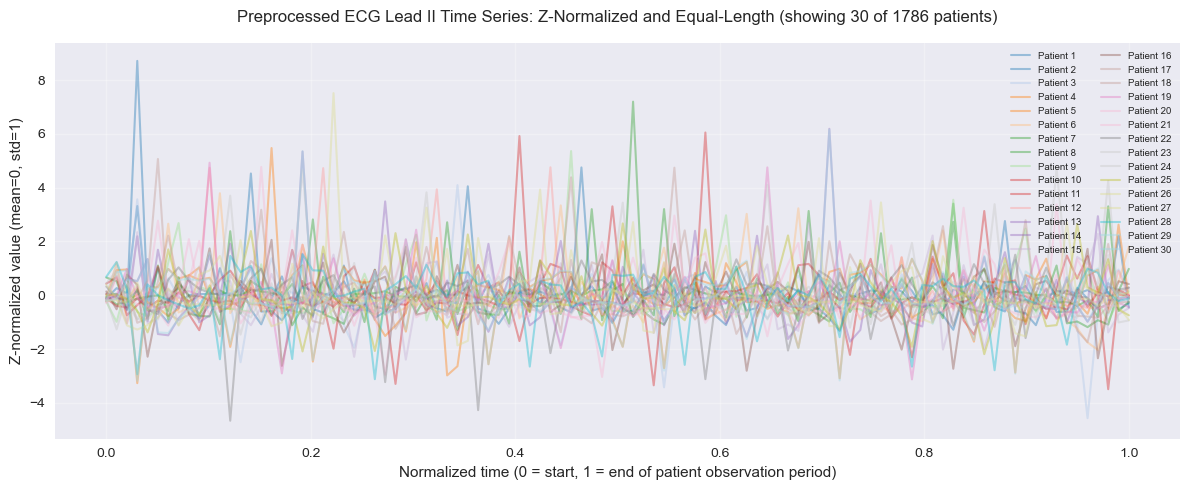

In [2]:
# Visualize a subset of normalized time series
plt.figure(figsize=(12, 5))
n_show = min(30, X_ts.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(np.linspace(0.0, 1.0, X_ts.shape[1]), X_ts[i], alpha=0.4, linewidth=1.5, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"Preprocessed ECG Lead II Time Series: Z-Normalized and Equal-Length (showing {n_show} of {X_ts.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel("Normalized time (0 = start, 1 = end of patient observation period)", fontsize=11)
plt.ylabel("Z-normalized value (mean=0, std=1)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.savefig(plots_path / "5.1_preprocessed_ecg_timeseries.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# Feature extraction: PAA, SAX, and DFT

def paa(series, n_segments):
    series = np.asarray(series)
    n = len(series)
    if n_segments > n:
        raise ValueError("n_segments must be <= length of series")

    idx = np.linspace(0, n, n_segments + 1, dtype=int)
    segments = []
    for i in range(n_segments):
        start = idx[i]
        end = idx[i + 1]
        seg_mean = series[start:end].mean()
        segments.append(seg_mean)
    return np.array(segments)

def sax(time_series, n_segments, alphabet_size=4):
    """SAX: PAA then convert to symbols."""
    from scipy.stats import norm
    # Z-normalize
    ts = np.asarray(time_series)
    if np.std(ts) == 0:
        ts_norm = ts - np.mean(ts)
    else:
        ts_norm = (ts - np.mean(ts)) / np.std(ts)
    
    # Apply PAA
    paa_values = paa(ts_norm, n_segments)
    
    # Convert to symbols using breakpoints
    breakpoints = []
    for i in range(1, alphabet_size):
        breakpoints.append(norm.ppf(i / alphabet_size))
    sax_symbols = []
    for val in paa_values:
        symbol = 0
        for i, bp in enumerate(breakpoints):
            if val > bp:
                symbol = i + 1
        sax_symbols.append(symbol)
    
    return np.array(sax_symbols)

def dft_features(time_series, n_coefficients=20):
    """DFT: Extract Fourier coefficients."""
    from scipy.fft import fft
    ts = np.asarray(time_series)
    fft_vals = fft(ts)
    n_coeffs = min(n_coefficients, len(fft_vals) // 2)
    dft_features = np.abs(fft_vals[:n_coeffs])
    dft_features = dft_features / len(ts)
    
    return dft_features

# Extract features using all three methods
n_segments = 20  # PAA and SAX dimensionality
n_dft_coefficients = 20  # DFT dimensionality
sax_alphabet_size = 4

X_paa = np.vstack([paa(ts, n_segments) for ts in X_ts])
X_sax = np.vstack([sax(ts, n_segments, alphabet_size=sax_alphabet_size) for ts in X_ts])
X_dft = np.vstack([dft_features(ts, n_coefficients=n_dft_coefficients) for ts in X_ts])

# Combine all features
X_combined = np.hstack([X_paa, X_sax, X_dft])

print(f"PAA feature matrix shape (patients x segments): {X_paa.shape}")
print(f"SAX feature matrix shape (patients x segments): {X_sax.shape}")
print(f"DFT feature matrix shape (patients x coefficients): {X_dft.shape}")
print(f"Combined feature matrix shape (patients x features): {X_combined.shape}")

PAA feature matrix shape (patients x segments): (1786, 20)
SAX feature matrix shape (patients x segments): (1786, 20)
DFT feature matrix shape (patients x coefficients): (1786, 20)
Combined feature matrix shape (patients x features): (1786, 60)


## PAA Features

PAA reduces each time series to 20 segments (mean values). Reduces dimensionality from 100 to 20 while preserving shape.

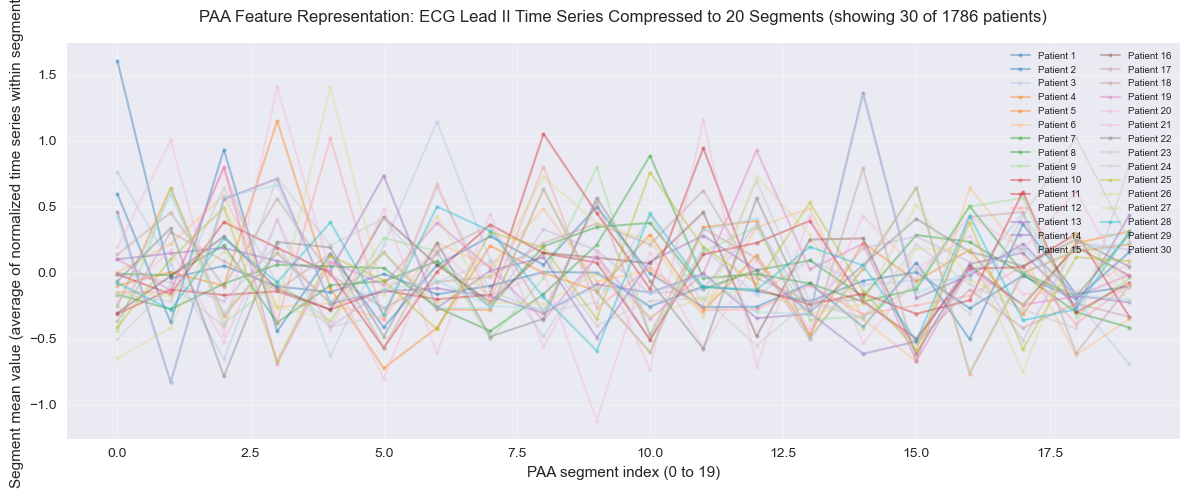

In [4]:
# Visualize PAA feature representation
plt.figure(figsize=(12, 5))
n_show = min(30, X_paa.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(range(n_segments), X_paa[i], alpha=0.4, linewidth=1.5, marker='o', markersize=3, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"PAA Feature Representation: ECG Lead II Time Series Compressed to {n_segments} Segments (showing {n_show} of {X_paa.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel(f"PAA segment index (0 to {n_segments-1})", fontsize=11)
plt.ylabel("Segment mean value (average of normalized time series within segment)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.savefig(plots_path / "5.1_paa_representation.jpg", dpi=300, bbox_inches='tight')
plt.show()

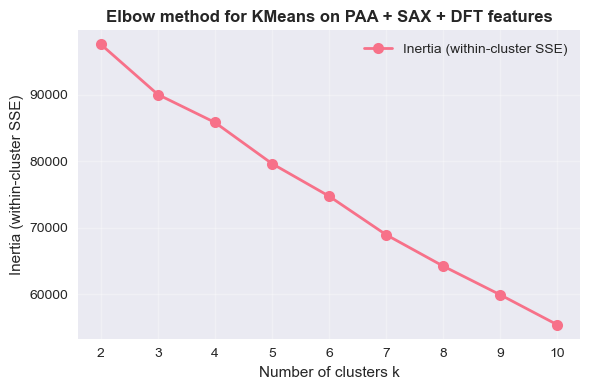

In [ ]:
# KMeans clustering with elbow method

scaler = StandardScaler()
X_paa_scaled = scaler.fit_transform(X_paa)

ks = range(2, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_paa_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(ks), inertias, marker="o", linewidth=2, markersize=8, label="Inertia (within-cluster SSE)")
plt.xlabel("Number of clusters k", fontsize=11)
plt.ylabel("Inertia (within-cluster SSE)", fontsize=11)
plt.title("Elbow method for KMeans on PAA features", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(plots_path / "5.2_kmeans_elbow.jpg", dpi=300, bbox_inches='tight')
plt.show()

## Clustering

All clustering algorithms use only PAA features. Tabular data used later for cluster interpretation only.

0    343
1    202
2    322
3    378
4    541
Name: count, dtype: int64


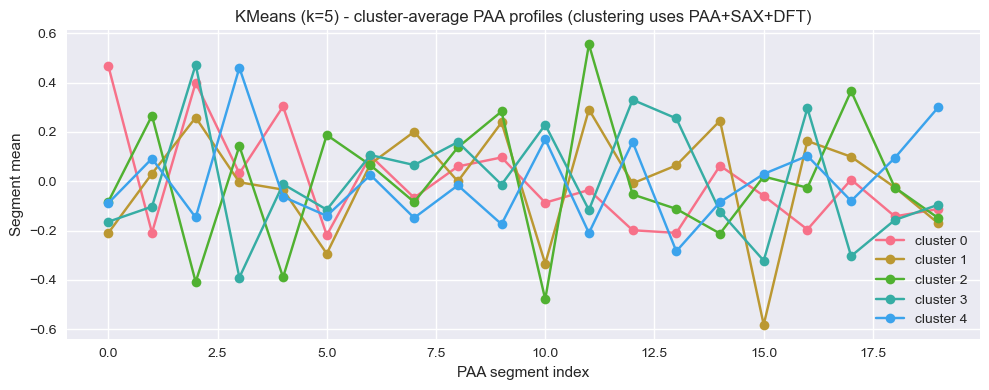

Silhouette score (KMeans, k=5): 0.172


In [ ]:
# Choose k after inspecting the elbow plot
k_kmeans = 5  # adjust if elbow suggests a different value

kmeans = KMeans(n_clusters=k_kmeans, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_paa_scaled)

print(pd.Series(kmeans_labels).value_counts().sort_index())


def plot_cluster_profiles(X_paa, labels, title, alpha=1.0, legend_text=None, save_path=None):
    """
    Plot cluster average PAA profiles.
    
    Parameters:
    -----------
    X_paa : array-like
        PAA feature matrix
    labels : array-like
        Cluster labels
    title : str
        Plot title
    alpha : float, default=1.0
        Opacity of the plot lines (0.0 to 1.0)
    legend_text : str or None, default=None
        Custom legend text. If None, shows individual cluster labels.
    save_path : Path or None, default=None
        Path to save the figure. If None, figure is not saved.
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    plt.figure(figsize=(10, 4))
    for lab in unique_labels:
        cluster_mean = X_paa[labels == lab].mean(axis=0)
        plt.plot(range(n_segments), cluster_mean, marker="o", label=f"cluster {lab}", alpha=alpha)
    
    plt.xlabel("PAA segment index")
    plt.ylabel("Segment mean")
    plt.title(title)
    
    if legend_text is not None:
        # Use custom legend text
        plt.legend([legend_text], loc='best', fontsize=9)
    else:
        # Use default individual cluster labels
        plt.legend()
    
    plt.grid(True)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_cluster_profiles(X_paa, kmeans_labels, f"KMeans (k={k_kmeans}) - cluster-average PAA profiles", save_path=plots_path / "5.2_kmeans_cluster_profiles.jpg")

sil_kmeans = silhouette_score(X_paa_scaled, kmeans_labels)
print(f"Silhouette score (KMeans, k={k_kmeans}): {sil_kmeans:.3f}")

# PCA and UMAP visualizations for KMeans (using PAA features)
print("\nCreating PCA and UMAP visualizations for KMeans clusters...")

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_paa_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title(f'KMeans Clusters - PCA (PAA features)', fontsize=12, fontweight='bold')
axes[0].legend(*scatter.legend_elements(), title='Cluster', loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# UMAP visualization
if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = reducer.fit_transform(X_paa_scaled)
    
    scatter = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6, s=20)
    axes[1].set_xlabel('UMAP 1', fontsize=11)
    axes[1].set_ylabel('UMAP 2', fontsize=11)
    axes[1].set_title(f'KMeans Clusters - UMAP (PAA features)', fontsize=12, fontweight='bold')
    axes[1].legend(*scatter.legend_elements(), title='Cluster', loc='best', fontsize=9)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'UMAP not available', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('UMAP (not available)', fontsize=12)

plt.tight_layout()
plt.savefig(plots_path / "5.2_kmeans_pca_umap.jpg", dpi=300, bbox_inches='tight')
plt.show()

## Cluster Profiling

Patient characteristics by cluster (age, gender, diagnosis).

In [7]:
# Load heart diagnoses data for cluster interpretation
df_heart = pd.read_csv(data_path / "heart_diagnoses_1.csv")
df_heart["charttime"] = pd.to_datetime(df_heart["charttime"], errors="coerce")

print(f"Heart Diagnoses loaded: {len(df_heart):,} rows")
print(f"Unique subjects: {df_heart['subject_id'].nunique():,}")

# Extract patient metadata and merge with cluster labels
# Get unique patient metadata from heart_diagnoses (age, gender, diagnosis)
patient_metadata = df_heart[
    ['subject_id', 'gender', 'age', 'icd_code', 'long_title']
].drop_duplicates(subset='subject_id').copy()

# Create a dataframe with patient_id and cluster label
cluster_df = pd.DataFrame({
    'subject_id': patient_ids,
    'cluster': kmeans_labels
})

# Merge cluster labels with patient metadata
cluster_profiles = cluster_df.merge(patient_metadata, on='subject_id', how='left')

print(f"Patients with cluster labels: {len(cluster_df)}")
print(f"Patients with metadata: {cluster_profiles['gender'].notna().sum()}")
print(f"\nCluster sizes:")
print(cluster_profiles['cluster'].value_counts().sort_index())
cluster_profiles.head(10)

Heart Diagnoses loaded: 4,864 rows
Unique subjects: 4,392
Patients with cluster labels: 1786
Patients with metadata: 1184

Cluster sizes:
cluster
0    343
1    202
2    322
3    378
4    541
Name: count, dtype: int64


,subject_id,cluster,gender,age,icd_code,long_title
0,10000980,0,F,75.0,I50,Heart failure
1,10004457,0,M,66.0,I35,Nonrheumatic aortic valve disorders
2,10007058,2,M,48.0,I21,Acute myocardial infarction
3,10018684,2,M,48.0,I48,Atrial fibrillation and flutter
4,10044096,4,M,53.0,I21,Acute myocardial infarction
5,10051074,3,F,71.0,I21,Acute myocardial infarction
6,10059952,4,M,73.0,I21,Acute myocardial infarction
7,10064049,3,M,70.0,I50,Heart failure
8,10075925,2,F,54.0,I50,Heart failure
9,10076616,1,M,64.0,I47,Paroxysmal tachycardia


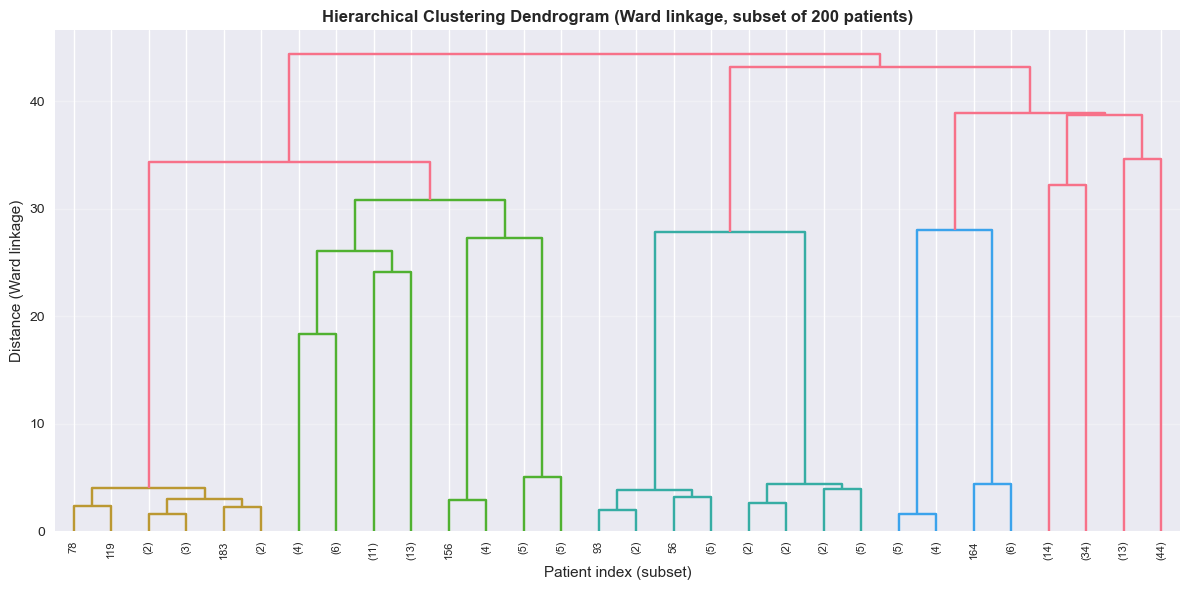

In [ ]:
# Optional: Dendrogram visualization (on a subset for clarity)
from scipy.cluster.hierarchy import linkage, dendrogram

subset_size = min(200, X_paa_scaled.shape[0])
X_sub = X_paa_scaled[:subset_size]

Z = linkage(X_sub, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=4, leaf_rotation=90, leaf_font_size=8)
plt.title(f"Hierarchical Clustering Dendrogram (Ward linkage, subset of {subset_size} patients)", fontsize=12, fontweight='bold')
plt.xlabel("Patient index (subset)", fontsize=11)
plt.ylabel("Distance (Ward linkage)", fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(plots_path / "5.3_hierarchical_dendrogram.jpg", dpi=300, bbox_inches='tight')
plt.show()

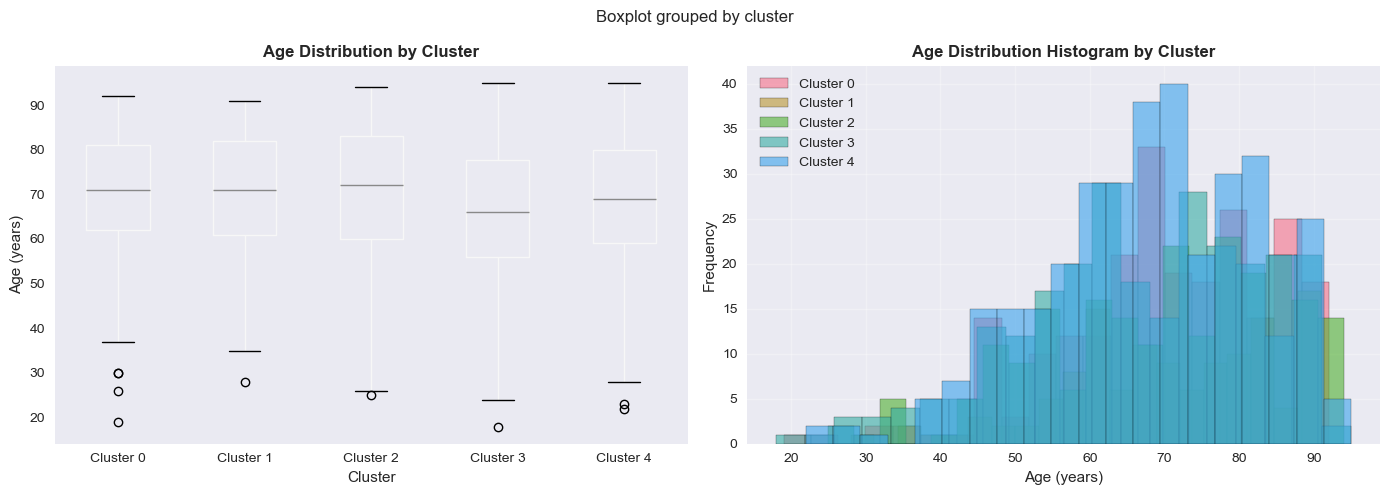

Age Statistics by Cluster:
         count       mean        std   min   25%   50%    75%   max
cluster                                                            
0        233.0  70.317597  14.158660  19.0  62.0  71.0  81.00  92.0
1        126.0  70.746032  14.246929  28.0  61.0  71.0  82.00  91.0
2        223.0  70.026906  15.350828  25.0  60.0  72.0  83.00  94.0
3        250.0  66.252000  15.601349  18.0  56.0  66.0  77.75  95.0
4        352.0  68.528409  14.276444  22.0  59.0  69.0  80.00  95.0


In [9]:
# Age distribution by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of age by cluster
cluster_profiles.boxplot(column='age', by='cluster', ax=axes[0], grid=False)
axes[0].set_title('Age Distribution by Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Age (years)', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)])

# Histogram of age distributions
for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_ages = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['age'].dropna()
    axes[1].hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster_id}', bins=20, edgecolor='black')

axes[1].set_title('Age Distribution Histogram by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age (years)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_path / "5.5_age_distribution_clusters.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("Age Statistics by Cluster:")
print(cluster_profiles.groupby('cluster')['age'].describe())

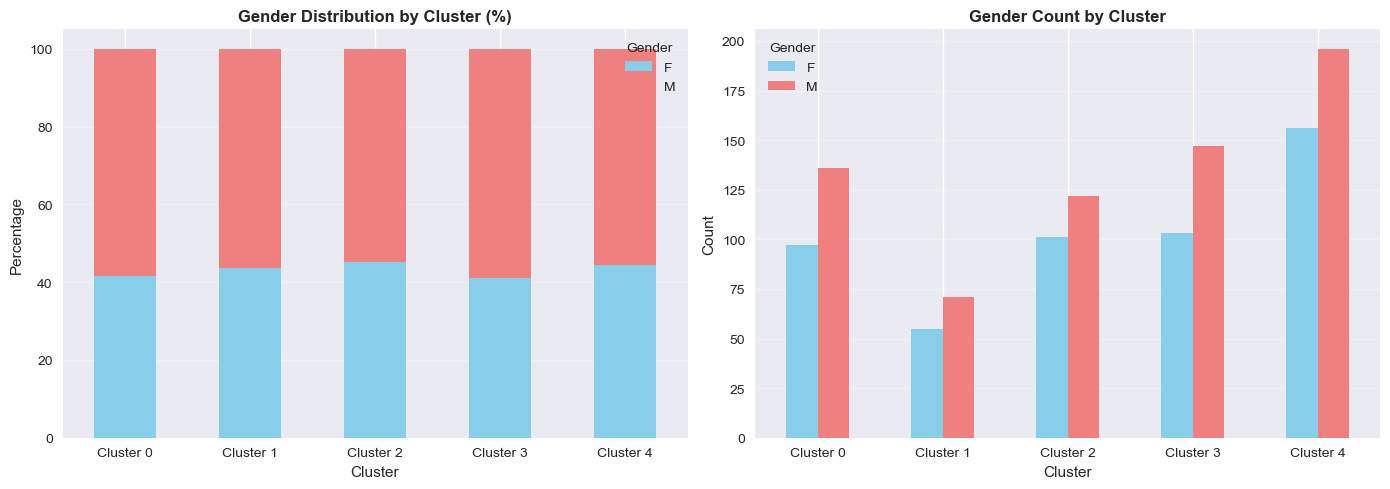

Gender Distribution by Cluster:
gender     F    M   All
cluster                
0         97  136   233
1         55   71   126
2        101  122   223
3        103  147   250
4        156  196   352
All      512  672  1184


In [10]:
# Gender distribution by cluster
gender_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
gender_cluster.plot(kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Gender Distribution by Cluster (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Percentage', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[0].legend(title='Gender', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Count bar chart
gender_counts = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'])
gender_counts.plot(kind='bar', ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_title('Gender Count by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[1].legend(title='Gender', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(plots_path / "5.5_gender_distribution_clusters.jpg", dpi=300, bbox_inches='tight')
plt.show()

print("Gender Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], margins=True))

Top 5 Diagnoses per Cluster:

Cluster 0 (n=343):
  1. Acute myocardial infarction: 76 (22.2%)
  2. Heart failure: 57 (16.6%)
  3. Atrial fibrillation and flutter: 38 (11.1%)
  4. Chronic ischemic heart disease: 21 (6.1%)
  5. Other diseases of pericardium: 8 (2.3%)

Cluster 1 (n=202):
  1. Acute myocardial infarction: 38 (18.8%)
  2. Heart failure: 36 (17.8%)
  3. Atrial fibrillation and flutter: 16 (7.9%)
  4. Chronic ischemic heart disease: 11 (5.4%)
  5. Nonrheumatic aortic valve disorders: 5 (2.5%)

Cluster 2 (n=322):
  1. Acute myocardial infarction: 84 (26.1%)
  2. Heart failure: 47 (14.6%)
  3. Chronic ischemic heart disease: 27 (8.4%)
  4. Atrial fibrillation and flutter: 24 (7.5%)
  5. Nonrheumatic aortic valve disorders: 10 (3.1%)

Cluster 3 (n=378):
  1. Acute myocardial infarction: 95 (25.1%)
  2. Heart failure: 58 (15.3%)
  3. Chronic ischemic heart disease: 31 (8.2%)
  4. Atrial fibrillation and flutter: 22 (5.8%)
  5. Other diseases of pericardium: 10 (2.6%)

Cluster 4 (

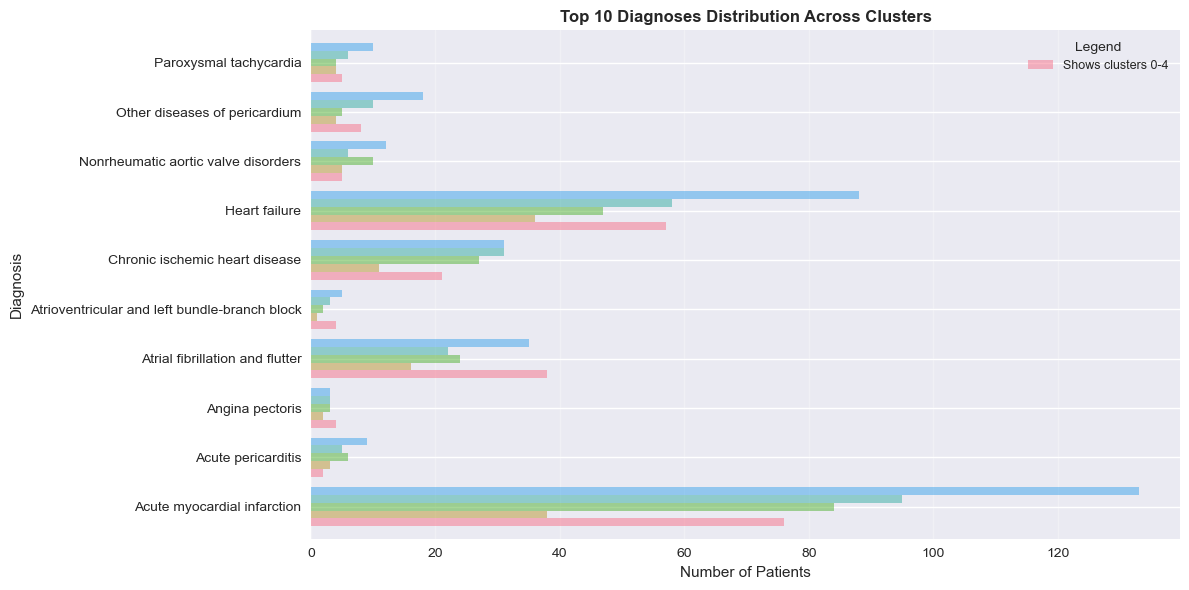

In [11]:
# Top diagnoses by cluster
print("Top 5 Diagnoses per Cluster:")
print("=" * 80)

for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_diag = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['long_title'].value_counts().head(5)
    print(f"\nCluster {cluster_id} (n={len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])}):")
    for idx, (diag, count) in enumerate(cluster_diag.items(), 1):
        pct = (count / len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])) * 100
        print(f"  {idx}. {diag}: {count} ({pct:.1f}%)")

# Visualize most common diagnoses across clusters
top_diag_overall = cluster_profiles['long_title'].value_counts().head(10).index.tolist()

fig, ax = plt.subplots(figsize=(12, 6))
diag_cluster = pd.crosstab(cluster_profiles['long_title'], cluster_profiles['cluster'])
diag_cluster_filtered = diag_cluster[diag_cluster.index.isin(top_diag_overall)]

diag_cluster_filtered.plot(kind='barh', ax=ax, width=0.8, alpha=0.5)
ax.set_title(f'Top 10 Diagnoses Distribution Across Clusters', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Patients', fontsize=11)
ax.set_ylabel('Diagnosis', fontsize=11)
ax.legend([f'Shows clusters 0-{k_kmeans-1}'], title='Legend', fontsize=9, loc='best')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(plots_path / "5.5_diagnosis_distribution_clusters.jpg", dpi=300, bbox_inches='tight')
plt.show()

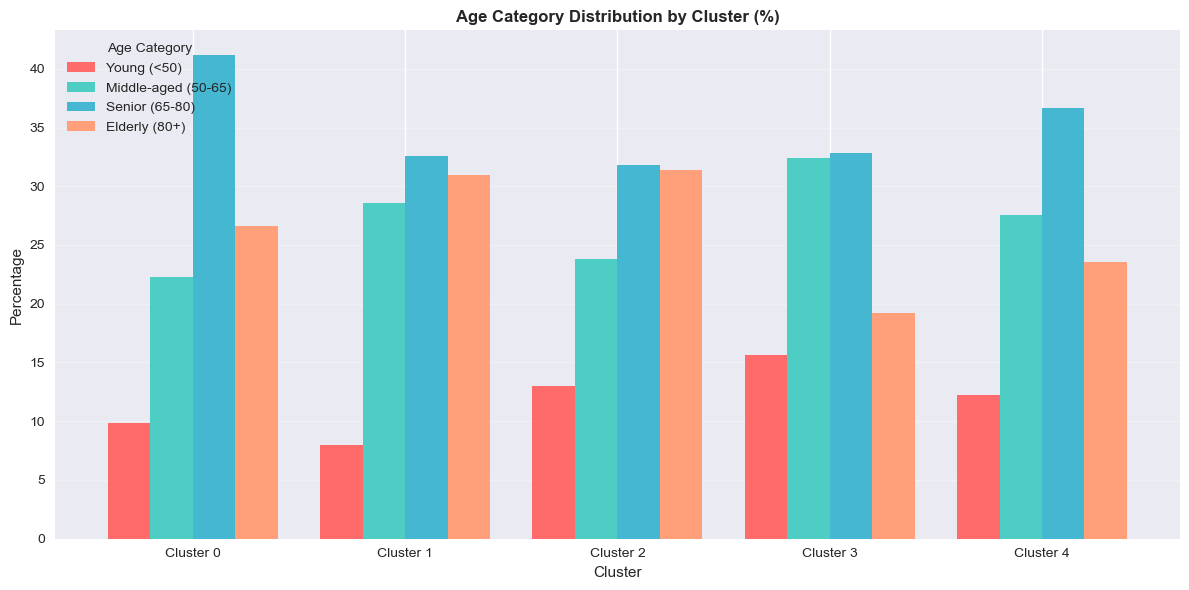

Age Category Distribution by Cluster:
age_category  Young (<50)  Middle-aged (50-65)  Senior (65-80)  Elderly (80+)  \
cluster                                                                         
0                      23                   52              96             62   
1                      10                   36              41             39   
2                      29                   53              71             70   
3                      39                   81              82             48   
4                      43                   97             129             83   
All                   144                  319             419            302   

age_category   All  
cluster             
0              233  
1              126  
2              223  
3              250  
4              352  
All           1184  


In [12]:
# Create age categories for easier interpretation
cluster_profiles['age_category'] = pd.cut(
    cluster_profiles['age'], 
    bins=[0, 50, 65, 80, 120], 
    labels=['Young (<50)', 'Middle-aged (50-65)', 'Senior (65-80)', 'Elderly (80+)']
)

# Age category distribution by cluster
age_cat_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(12, 6))
age_cat_cluster.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], width=0.8)
ax.set_title('Age Category Distribution by Cluster (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Percentage', fontsize=11)
ax.set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
ax.legend(title='Age Category', fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(plots_path / "5.5_age_category_clusters.jpg", dpi=300, bbox_inches='tight')
plt.show()

print("Age Category Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], margins=True))

### Cluster Summary

Cluster characteristics based on age, gender, and diagnosis patterns.

0    198
1    413
2    595
3    275
4    305
Name: count, dtype: int64


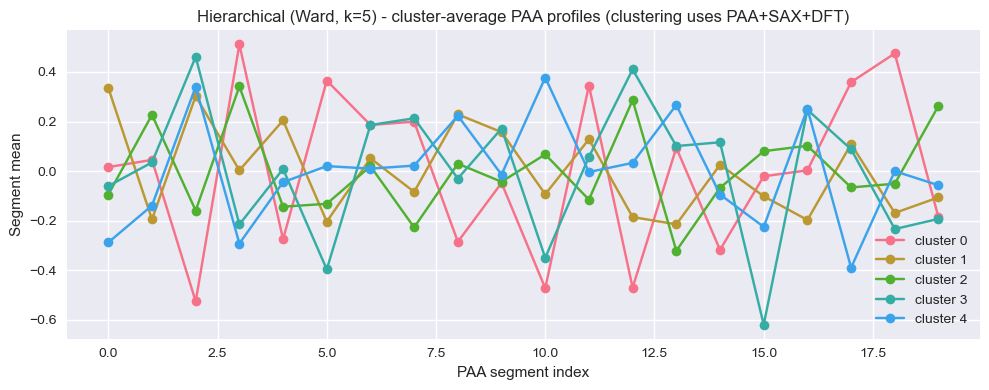

Silhouette score (Hierarchical, k=5): 0.186


In [ ]:
# Hierarchical clustering (Ward linkage)

hier = AgglomerativeClustering(n_clusters=k_kmeans, linkage="ward")
hier_labels = hier.fit_predict(X_combined_scaled)

print(pd.Series(hier_labels).value_counts().sort_index())

plot_cluster_profiles(X_paa, hier_labels, f"Hierarchical (Ward, k={k_kmeans}) - cluster-average PAA profiles (clustering uses PAA+SAX+DFT)", save_path=plots_path / "5.3_hierarchical_cluster_profiles.jpg")

sil_hier = silhouette_score(X_combined_scaled, hier_labels)
print(f"Silhouette score (Hierarchical, k={k_kmeans}): {sil_hier:.3f}")

# PCA and UMAP visualizations for Hierarchical clustering (using PAA+SAX+DFT features)
print("\nCreating PCA and UMAP visualizations for Hierarchical clusters...")

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_combined_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=hier_labels, cmap='tab10', alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title(f'Hierarchical Clusters - PCA (PAA+SAX+DFT features)', fontsize=12, fontweight='bold')
axes[0].legend(*scatter.legend_elements(), title='Cluster', loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# UMAP visualization
if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = reducer.fit_transform(X_combined_scaled)
    
    scatter = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=hier_labels, cmap='tab10', alpha=0.6, s=20)
    axes[1].set_xlabel('UMAP 1', fontsize=11)
    axes[1].set_ylabel('UMAP 2', fontsize=11)
    axes[1].set_title(f'Hierarchical Clusters - UMAP (PAA+SAX+DFT features)', fontsize=12, fontweight='bold')
    axes[1].legend(*scatter.legend_elements(), title='Cluster', loc='best', fontsize=9)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'UMAP not available', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('UMAP (not available)', fontsize=12)

plt.tight_layout()
plt.savefig(plots_path / "5.3_hierarchical_pca_umap.jpg", dpi=300, bbox_inches='tight')
plt.show()

eps=0.5, min_samples=5 -> clusters=52, noise=1197
eps=0.5, min_samples=10 -> clusters=11, noise=1540
eps=0.5, min_samples=20 -> clusters=2, noise=1707
eps=0.8, min_samples=5 -> clusters=65, noise=516
eps=0.8, min_samples=10 -> clusters=36, noise=786
eps=0.8, min_samples=20 -> clusters=12, noise=1291
eps=1.0, min_samples=5 -> clusters=68, noise=423
eps=1.0, min_samples=10 -> clusters=43, noise=637
eps=1.0, min_samples=20 -> clusters=17, noise=1087
eps=1.2, min_samples=5 -> clusters=67, noise=338
eps=1.2, min_samples=10 -> clusters=47, noise=504
eps=1.2, min_samples=20 -> clusters=24, noise=871
DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35]
-1     786
 0      30
 1      28
 2      23
 3      16
 4      25
 5      16
 6      52
 7      68
 8      19
 9      29
 10     41
 11     37
 12     49
 13     59
 14     50
 15     24
 16     31
 17     54
 18     12
 19     55
 20     13
 21     17
 22     16
 23    

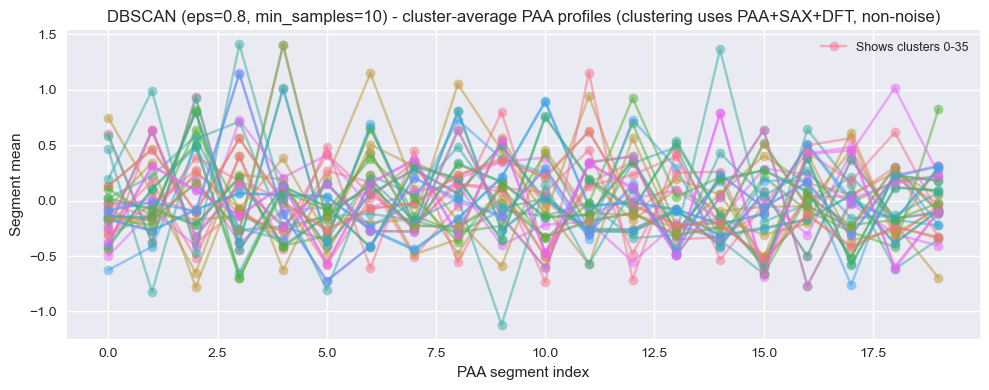

Silhouette score (DBSCAN, non-noise only): 0.740


In [ ]:
# DBSCAN clustering

# Try a couple of parameter combinations and inspect results
for eps in [0.5, 0.8, 1.0, 1.2]:
    for min_samples in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_combined_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        print(f"eps={eps}, min_samples={min_samples} -> clusters={n_clusters}, noise={n_noise}")

# Choose a reasonable combination after inspecting the above output
eps_db = 0.8
min_samples_db = 10

dbscan = DBSCAN(eps=eps_db, min_samples=min_samples_db)
dbscan_labels = dbscan.fit_predict(X_combined_scaled)

unique_db_labels = np.unique(dbscan_labels)
print("DBSCAN labels:", unique_db_labels)
print(pd.Series(dbscan_labels).value_counts().sort_index())

mask_non_noise = dbscan_labels != -1
if mask_non_noise.sum() > 0:
    # Get unique cluster labels (excluding noise -1)
    unique_clusters = np.unique(dbscan_labels[mask_non_noise])
    n_clusters_found = len(unique_clusters)
    min_cluster = int(unique_clusters.min())
    max_cluster = int(unique_clusters.max())
    
    # Create legend text
    if n_clusters_found > 1:
        legend_text = f"Shows clusters {min_cluster}-{max_cluster}"
    else:
        legend_text = f"Shows cluster {min_cluster}"
    
    plot_cluster_profiles(
        X_paa[mask_non_noise],
        dbscan_labels[mask_non_noise],
        f"DBSCAN (eps={eps_db}, min_samples={min_samples_db}) - cluster-average PAA profiles (clustering uses PAA+SAX+DFT, non-noise)",
        alpha=0.5,
        legend_text=legend_text,
        save_path=plots_path / "5.4_dbscan_cluster_profiles.jpg"
    )
    
    # Calculate silhouette score for non-noise points only
    if n_clusters_found >= 2:
        sil_dbscan = silhouette_score(X_combined_scaled[mask_non_noise], dbscan_labels[mask_non_noise])
        print(f"Silhouette score (DBSCAN, non-noise only): {sil_dbscan:.3f}")
    else:
        print("Cannot calculate silhouette score: need at least 2 clusters")
    
    # PCA and UMAP visualizations for DBSCAN (using PAA+SAX+DFT features)
    print("\nCreating PCA and UMAP visualizations for DBSCAN clusters...")
    
    # PCA visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_combined_scaled)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # PCA plot - show noise points separately
    # Plot noise points first (in gray)
    noise_mask = dbscan_labels == -1
    if noise_mask.sum() > 0:
        axes[0].scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], c='gray', alpha=0.3, s=10, label='Noise', marker='x')
    
    # Plot cluster points
    scatter = axes[0].scatter(X_pca[mask_non_noise, 0], X_pca[mask_non_noise, 1], 
                              c=dbscan_labels[mask_non_noise], cmap='tab10', alpha=0.6, s=20)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
    axes[0].set_title(f'DBSCAN Clusters - PCA (PAA+SAX+DFT features)', fontsize=12, fontweight='bold')
    if noise_mask.sum() > 0:
        axes[0].legend([*scatter.legend_elements()[0], plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='gray', markersize=8, alpha=0.5)], 
                      [*scatter.legend_elements()[1], 'Noise'], title='Label', loc='best', fontsize=9)
    else:
        axes[0].legend(*scatter.legend_elements(), title='Cluster', loc='best', fontsize=9)
    axes[0].grid(True, alpha=0.3)
    
    # UMAP visualization
    if UMAP_AVAILABLE:
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        X_umap = reducer.fit_transform(X_combined_scaled)
        
        # Plot noise points first (in gray)
        if noise_mask.sum() > 0:
            axes[1].scatter(X_umap[noise_mask, 0], X_umap[noise_mask, 1], c='gray', alpha=0.3, s=10, label='Noise', marker='x')
        
        # Plot cluster points
        scatter = axes[1].scatter(X_umap[mask_non_noise, 0], X_umap[mask_non_noise, 1], 
                                 c=dbscan_labels[mask_non_noise], cmap='tab10', alpha=0.6, s=20)
        axes[1].set_xlabel('UMAP 1', fontsize=11)
        axes[1].set_ylabel('UMAP 2', fontsize=11)
        axes[1].set_title(f'DBSCAN Clusters - UMAP (PAA+SAX+DFT features)', fontsize=12, fontweight='bold')
        if noise_mask.sum() > 0:
            axes[1].legend([*scatter.legend_elements()[0], plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='gray', markersize=8, alpha=0.5)], 
                          [*scatter.legend_elements()[1], 'Noise'], title='Label', loc='best', fontsize=9)
        else:
            axes[1].legend(*scatter.legend_elements(), title='Cluster', loc='best', fontsize=9)
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'UMAP not available', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('UMAP (not available)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(plots_path / "5.4_dbscan_pca_umap.jpg", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("All points considered noise for current DBSCAN parameters.")

Patients with DBSCAN cluster labels: 1786
Patients with metadata: 1184

DBSCAN Cluster sizes:
cluster
-1     786
 0      30
 1      28
 2      23
 3      16
 4      25
 5      16
 6      52
 7      68
 8      19
 9      29
 10     41
 11     37
 12     49
 13     59
 14     50
 15     24
 16     31
 17     54
 18     12
 19     55
 20     13
 21     17
 22     16
 23     16
 24     42
 25     10
 26     24
 27     28
 28     21
 29     23
 30     12
 31     16
 32     10
 33     11
 34     11
 35     12
Name: count, dtype: int64

Top 5 Diagnoses per DBSCAN Cluster:

Noise (n=786):
  1. Acute myocardial infarction: 190 (24.2%)
  2. Heart failure: 128 (16.3%)
  3. Atrial fibrillation and flutter: 65 (8.3%)
  4. Chronic ischemic heart disease: 52 (6.6%)
  5. Other diseases of pericardium: 19 (2.4%)

Cluster 0 (n=30):
  1. Acute myocardial infarction: 9 (30.0%)
  2. Heart failure: 6 (20.0%)
  3. Chronic ischemic heart disease: 1 (3.3%)
  4. Acute pericarditis: 1 (3.3%)
  5. Angina pectoris

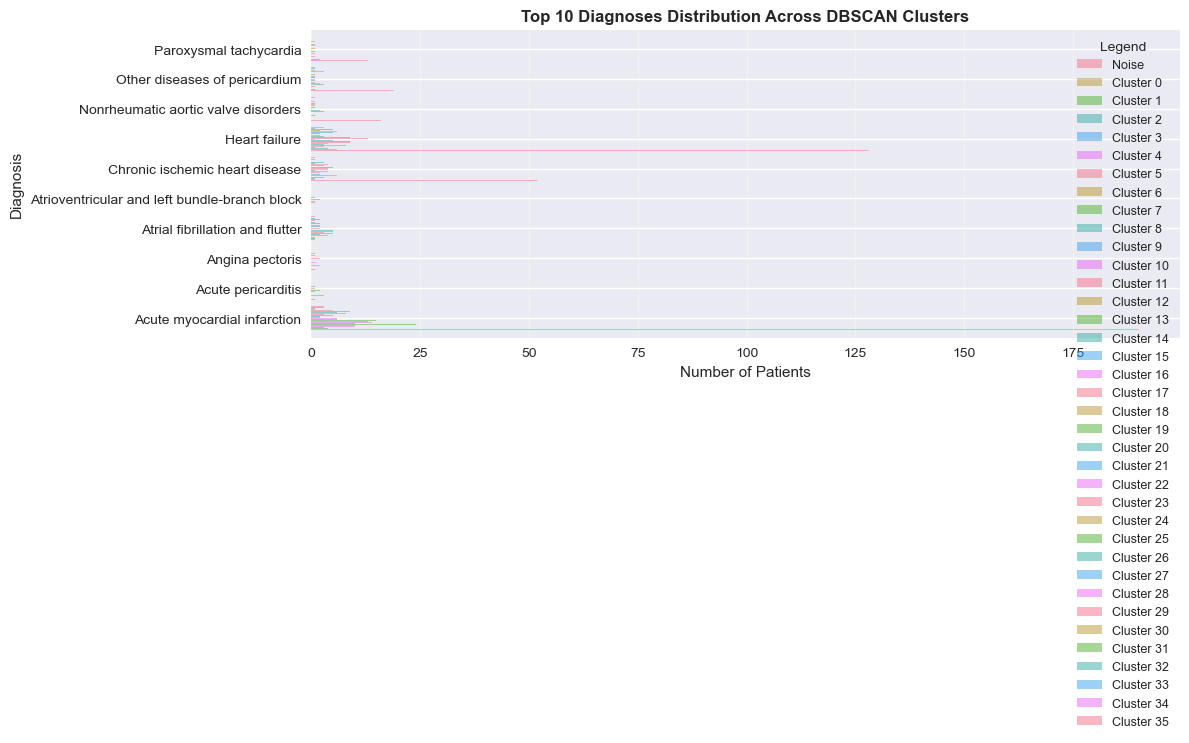


Diagnosis Distribution by DBSCAN Cluster:
cluster                                              -1   0   1   2   3   4  \
long_title                                                                    
Acute and subacute endocarditis                       3   0   0   0   0   0   
Acute myocardial infarction                         190   9   4   3   4  10   
Acute myocarditis                                     4   0   0   0   0   0   
Acute pericarditis                                   14   1   0   0   0   0   
Angina pectoris                                       3   1   0   1   0   0   
Atrial fibrillation and flutter                      65   1   1   3   1   0   
Atrioventricular and left bundle-branch block         9   0   0   0   0   0   
Cardiomyopathy                                        3   0   0   0   0   0   
Chronic ischemic heart disease                       52   1   1   1   3   0   
Heart failure                                       128   6   3   4   1   3   
Nonrheuma

In [ ]:
# Create DBSCAN cluster profiles with patient metadata
cluster_df_dbscan = pd.DataFrame({
    'subject_id': patient_ids,
    'cluster': dbscan_labels
})

# Merge cluster labels with patient metadata
cluster_profiles_dbscan = cluster_df_dbscan.merge(patient_metadata, on='subject_id', how='left')

print(f"Patients with DBSCAN cluster labels: {len(cluster_df_dbscan)}")
print(f"Patients with metadata: {cluster_profiles_dbscan['gender'].notna().sum()}")
print(f"\nDBSCAN Cluster sizes:")
print(cluster_profiles_dbscan['cluster'].value_counts().sort_index())

# Top diagnoses by cluster (including noise as -1)
print("\nTop 5 Diagnoses per DBSCAN Cluster:")
print("=" * 80)

for cluster_id in sorted(cluster_profiles_dbscan['cluster'].unique()):
    cluster_data = cluster_profiles_dbscan[cluster_profiles_dbscan['cluster'] == cluster_id]
    cluster_diag = cluster_data['long_title'].value_counts().head(5)
    cluster_name = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"\n{cluster_name} (n={len(cluster_data)}):")
    for idx, (diag, count) in enumerate(cluster_diag.items(), 1):
        pct = (count / len(cluster_data)) * 100
        print(f"  {idx}. {diag}: {count} ({pct:.1f}%)")

# Visualize most common diagnoses across DBSCAN clusters
# For each diagnosis, show only the top 5 clusters with highest frequency
top_diag_overall_dbscan = cluster_profiles_dbscan['long_title'].value_counts().head(10).index.tolist()

# Create a 2x5 grid of subplots (one per diagnosis)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for idx, diagnosis in enumerate(top_diag_overall_dbscan):
    ax = axes[idx]
    
    # Filter data for this specific diagnosis
    diag_data = cluster_profiles_dbscan[cluster_profiles_dbscan['long_title'] == diagnosis]
    
    # Count occurrences per cluster and get top 5
    cluster_counts = diag_data['cluster'].value_counts().head(5)
    
    # Create labels for clusters
    cluster_labels = [f'Noise' if c == -1 else f'Cluster {c}' for c in cluster_counts.index]
    
    # Plot horizontal bars
    bars = ax.barh(range(len(cluster_counts)), cluster_counts.values, alpha=0.7)
    ax.set_yticks(range(len(cluster_counts)))
    ax.set_yticklabels(cluster_labels)
    ax.set_xlabel('Number of Patients', fontsize=9)
    ax.set_title(diagnosis, fontsize=10, fontweight='bold', pad=5)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, cluster_counts.values)):
        ax.text(count, i, f' {count}', va='center', fontsize=8)

plt.suptitle('Top 5 Clusters per Diagnosis (DBSCAN)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])

# Save to root directory with NEW_ prefix
root_path = base_path / "NEW_5.5_diagnosis_distribution_clusters_dbscan.jpg"
plt.savefig(root_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {root_path}")
plt.show()

print("\nDiagnosis Distribution by DBSCAN Cluster:")
print(pd.crosstab(cluster_profiles_dbscan['long_title'], cluster_profiles_dbscan['cluster'], margins=True))

### Summary

**Preprocessing:** ECG Lead II → z-normalization → PAA (20 segments)

**Methods:**
- KMeans: Elbow method for k selection
- Hierarchical: Ward linkage, dendrogram
- DBSCAN: Density-based, identifies noise

PAA features only.